## Convolutional NN to classify govuk content to level2 taxons

Based on:
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

## To do:
- ~~Consider grouping very small classes (especially if too small for evaluation)~~
- ~~Split data into training, validation and test to avoid overfitting validation data during hyperparamter searches & model architecture changes~~
- ~~Try learning embeddings~~--
- Try changing pos_ratio
- Try implementing class_weights during model fit (does this do the same as the weighted binary corss entropy?)
- Work on tensorboard callbacks
- ~~Create dictionary of class indices to taxon names for viewing results~~
- Check model architecture
- consider relationship of training error to validation error - overfitting/bias?
- train longer
- Try differnet max_sequence_length
- Check batch size is appropriate
- Also think about:
  - regularization (e.g. dropout) 
  - fine-tuning the Embedding layer

### Load requirements and data

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical, layer_utils, plot_model

from keras.layers import (Embedding, Input, Dense, 
                          Activation, Conv1D, MaxPooling1D, Flatten)
from keras.models import Model, Sequential
from keras.optimizers import rmsprop
from keras.callbacks import TensorBoard, Callback
import keras.backend as K
from keras.losses import binary_crossentropy

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.utils import class_weight

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import functools


Using TensorFlow backend.


### Envoronmental vars

In [2]:
DATADIR=os.getenv('DATADIR')

## Hyperparameters

In [3]:
#MAX_NB_WORDS
MAX_SEQUENCE_LENGTH =1000
EMBEDDING_DIM = 100 # used 6B.100d.txt
P_THRESHOLD = 0.5 #Threshold for probability of being assigned to class
POS_RATIO = 0.5 #ratio of positive to negative for each class in weighted binary cross entropy loss function

### Read in data
Content items tagged to level 2 taxons or lower in the topic taxonomy

In [4]:
labelled_level2 = pd.read_csv(os.path.join(DATADIR, 'labelled_level2.csv'), dtype=object)

### Create target/Y 

Note: when using the categorical_crossentropy loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros expect for a 1 at the index corresponding to the class of the sample). In order to convert integer targets into categorical targets, you can use the Keras utility to_categorical

In [5]:
#COLLAPSE World level2taxons
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

In [6]:
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

labels = labelled_level2['level2taxon'].cat.codes + 1 

In [7]:
labels_index = dict(zip((labels), labelled_level2['level2taxon']))
labels_index

{1: 'Administrative justice reform',
 2: 'Adoption, fostering and surrogacy',
 3: 'Afghanistan',
 4: 'Armed Forces Covenant',
 5: 'Armed forces',
 6: 'Armed forces and Ministry of Defence reform',
 7: 'Armed forces support for activities in the UK',
 8: 'Arts and culture',
 9: 'Assessing environmental impact',
 10: 'Asylum',
 11: 'Attorney General guidance to the legal profession',
 12: 'Aviation',
 13: 'Benefits entitlement',
 14: 'Benefits for families',
 15: 'Biodiversity and ecosystems',
 16: 'Boating and inland waterways',
 17: 'Brexit',
 18: 'Brexit and the EU',
 19: 'British citizenship ',
 20: 'British nationals overseas',
 21: 'Business and enterprise',
 22: 'Business and the environment',
 23: 'Business tax',
 24: 'Byelaws',
 25: 'Carers and disability benefits',
 26: "Carers' health",
 27: 'Certificates, register offices, changes of name or gender',
 28: 'Charities, volunteering and honours',
 29: 'Child Benefit',
 30: 'Child maintenance reform',
 31: 'Childcare and early ye

In multilabel learning, the joint set of binary classification tasks is expressed with label binary indicator array: each sample is one row of a 2d array of shape (n_samples, n_classes) with binary values:  
the one, i.e. the non zero elements, corresponds to the subset of labels.  
An array such as np.array([[1, 0, 0], [0, 1, 1], [0, 0, 0]]) represents label 0 in the first sample, labels 1 and 2 in the second sample, and no labels in the third sample.  
Producing multilabel data as a list of sets of labels may be more intuitive. The MultiLabelBinarizer transformer can be used to convert between a collection of collections of labels and the indicator format.

####  first reshape wide to get columns for each level2taxon and row number = number unique urls

In [8]:
#get a smaller copy of data for pivoting ease (think you can work from full data actually and other cols get droopedauto)

level2_reduced = labelled_level2[['content_id', 'level2taxon', 'combined_text']].copy()

#how many level2taxons are there?
print(level2_reduced.level2taxon.nunique())

#count the number of taxons per content item into new column
level2_reduced['num_taxon_per_content'] = level2_reduced.groupby(["content_id"])['content_id'].transform("count")

#Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
level2_reduced['level2taxon_code'] = level2_reduced.level2taxon.astype('category').cat.codes + 1

210


In [9]:
#reshape to wide per taxon and keep the combined text so indexing is consistent when splitting X from Y

multilabel = (level2_reduced.pivot_table(index=['content_id', 'combined_text'], 
                  columns='level2taxon_code', 
                  values='num_taxon_per_content'))
print(level2_reduced.shape)
print(multilabel.shape)

(173560, 5)
(114048, 210)


In [10]:
#convert the number_of_taxons_per_content values to 1, meaning there was an entry for this taxon and this content_id, 0 otherwise
binary_multilabel = multilabel.notnull().astype('int')

In [11]:
#will convert columns to an array of shape
binary_multilabel[list(binary_multilabel.columns)].values.shape

(114048, 210)

In [12]:
#convert columns to an array. Each row represents a content item, each column an individual taxon
binary_multilabel = binary_multilabel[list(binary_multilabel.columns)].values
binary_multilabel[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [13]:
type(binary_multilabel)

numpy.ndarray

In [14]:
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(binary_multilabel)
# y.shape

In [15]:
#Use this for singlelabel problems
# labels = to_categorical(np.asarray(labels))

# print('Shape of label tensor:', labels.shape)

# labels

### Create language data/X

format our text samples and labels into tensors that can be fed into a neural network. To do this, we will rely on Keras utilities keras.preprocessing.text.Tokenizer and keras.preprocessing.sequence.pad_sequences.

In [16]:
multilabel.index.names
texts = multilabel.index.get_level_values('combined_text')
texts.shape

(114048,)

In [17]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) #yield one sequence per input text

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen= MAX_SEQUENCE_LENGTH) #MAX_SEQUENCE_LENGTH

Found 213132 unique tokens.


In [18]:
print('Shape of label tensor:', binary_multilabel.shape)
print('Shape of data tensor:', data.shape)

Shape of label tensor: (114048, 210)
Shape of data tensor: (114048, 1000)


### Data split
- Training data = 80%
- validation data = 10%
- Test data = 10%

In [19]:
# shuffle data and standardise indices
indices = np.arange(data.shape[0])
np.random.seed(0)
np.random.shuffle(indices)

In [20]:
data = data[indices]
labels = binary_multilabel[indices]

In [21]:
nb_test_samples = int(0.1 * data.shape[0]) #validation split
print('nb_test samples:', nb_test_samples)

nb_val_samples = int(0.2 * data.shape[0]) #validation split
print('nb_val samples:', nb_val_samples)

nb_training_samples = int(0.8 * data.shape[0]) #validation split
print('nb_training samples:', nb_training_samples)

nb_test samples: 11404
nb_val samples: 22809
nb_training samples: 91238


In [22]:
x_train = data[:-nb_val_samples]
print('Shape of x_train:', x_train.shape)
y_train = labels[:-nb_val_samples]
print('Shape of y_train:', y_train.shape)

x_val = data[-nb_val_samples:-nb_test_samples]
print('Shape of x_val:', x_val.shape)
y_val = labels[-nb_val_samples:-nb_test_samples]
print('Shape of y_val:', y_val.shape)

x_test = data[-nb_test_samples:]
print('Shape of x_val:', x_val.shape)
y_test = labels[-nb_test_samples:]
print('Shape of y_val:', y_val.shape)

Shape of x_train: (91239, 1000)
Shape of y_train: (91239, 210)
Shape of x_val: (11405, 1000)
Shape of y_val: (11405, 210)
Shape of x_val: (11405, 1000)
Shape of y_val: (11405, 210)


In [23]:
#check these are differnt arrays!
np.array_equal(y_val, y_test)

False

### preparing the Embedding layer

NB stopwords haven't been removed yet...

In [25]:
embedding_layer = Embedding(len(word_index) + 1, 
                            EMBEDDING_DIM, 
                            input_length=MAX_SEQUENCE_LENGTH)

An Embedding layer should be fed sequences of integers, i.e. a 2D input of shape (samples, indices). These input sequences should be padded so that they all have the same length in a batch of input data (although an Embedding layer is capable of processing sequence of heterogenous length, if you don't pass an explicit input_length argument to the layer).

All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix, i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]. This means that the output of the Embedding layer will be a 3D tensor of shape (samples, sequence_length, embedding_dim).

### Estimate class weights for unbalanced datasets.
paramter to model.fit = __class_weight__: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.

Implement class_weight from sklearn:

- Import the module 

`from sklearn.utils import class_weight`
- calculate the class weight, If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)):

`class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)`

- change it to a dict in order to work with Keras.

`class_weight_dict = dict(enumerate(class_weight))`

- Add to model fitting

`model.fit(X_train, y_train, class_weight=class_weight)`

In [26]:
# class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight_dict = dict(enumerate(class_weight))

### Custom loss function

In [27]:
class WeightedBinaryCrossEntropy(object):

    def __init__(self, pos_ratio):
        neg_ratio = 1. - pos_ratio
        #self.pos_ratio = tf.constant(pos_ratio, tf.float32)
        self.pos_ratio = pos_ratio
        #self.weights = tf.constant(neg_ratio / pos_ratio, tf.float32)
        self.weights = neg_ratio / pos_ratio
        self.__name__ = "weighted_binary_crossentropy({0})".format(pos_ratio)

    def __call__(self, y_true, y_pred):
        return self.weighted_binary_crossentropy(y_true, y_pred)

    def weighted_binary_crossentropy(self, y_true, y_pred):
            # Transform to logits
            epsilon = tf.convert_to_tensor(K.common._EPSILON, y_pred.dtype.base_dtype)
            y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
            y_pred = tf.log(y_pred / (1 - y_pred))

            cost = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, self.weights)
            return K.mean(cost * self.pos_ratio, axis=-1)
    
y_true_arr = np.array([0,1,0,1], dtype="float32")
y_pred_arr = np.array([0,0,1,1], dtype="float32")
y_true = tf.constant(y_true_arr)
y_pred = tf.constant(y_pred_arr)

with tf.Session().as_default(): 
    print(WeightedBinaryCrossEntropy(0.5)(y_true, y_pred).eval())
    print(binary_crossentropy(y_true, y_pred).eval())


4.00756
8.01512


### difficulty getting global precision/recall metrics . CAUTION interpreting monitoring metrics
fcholltet: "Basically these are all global metrics that were approximated
batch-wise, which is more misleading than helpful. This was mentioned in
the docs but it's much cleaner to remove them altogether. It was a mistake
to merge them in the first place."

In [28]:
def mcor(y_true, y_pred):
     #matthews_correlation
     y_pred_pos = K.round(K.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
 
 
     y_pos = K.round(K.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
 
 
     tp = K.sum(y_pos * y_pred_pos)
     tn = K.sum(y_neg * y_pred_neg)
 
 
     fp = K.sum(y_neg * y_pred_pos)
     fn = K.sum(y_pos * y_pred_neg)
 
 
     numerator = (tp * tn - fp * fn)
     denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
 
 
     return numerator / (denominator + K.epsilon())

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

## Training a 1D convnet

### 1. Create model

In [29]:
NB_CLASSES = y_train.shape[1]
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') #MAX_SEQUENCE_LENGTH
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, activation='relu', name = 'conv0')(embedded_sequences)

x = MaxPooling1D(5, name = 'max_pool0')(x)

x = Conv1D(128, 5, activation='relu', name = 'conv1')(x)

x = MaxPooling1D(5 , name = 'max_pool1')(x)

x = Conv1D(128, 5, activation='relu', name = 'conv2')(x)

x = MaxPooling1D(35, name = 'global_max_pool')(x)  # global max pooling

x = Flatten()(x) #reduce dimensions from 3 to 2; convert to vector + FULLYCONNECTED

x = Dense(128, activation='relu')(x)

x = Dense(NB_CLASSES, activation='sigmoid', name = 'fully_connected')(x)

# # The Model class turns an input tensor and output tensor into a model
# This creates Keras model instance, will use this instance to train/test the model.
model = Model(sequence_input, x)

In [30]:
sequence_input

<tf.Tensor 'input_1:0' shape=(?, 1000) dtype=int32>

### 2. Compile model

In [31]:
model.compile(loss=WeightedBinaryCrossEntropy(POS_RATIO),
              optimizer='rmsprop',
              metrics=['binary_accuracy', precision, recall, f1])

Metric values are recorded at the end of each epoch on the training dataset. If a validation dataset is also provided, then the metric recorded is also calculated for the validation dataset.

All metrics are reported in verbose output and in the history object returned from calling the fit() function. In both cases, the name of the metric function is used as the key for the metric values. In the case of metrics for the validation dataset, the “val_” prefix is added to the key.

You have now built a function to describe your model. To train and test this model, there are four steps in Keras:
1. Create the model by calling the function above
2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`
3. Train the model on train data by calling `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`
4. Test the model on test data by calling `model.evaluate(x = ..., y = ...)`

If you want to know more about `model.compile()`, `model.fit()`, `model.evaluate()` and their arguments, refer to the official [Keras documentation](https://keras.io/models/model/).


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         21313300  
_________________________________________________________________
conv0 (Conv1D)               (None, 996, 128)          64128     
_________________________________________________________________
max_pool0 (MaxPooling1D)     (None, 199, 128)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 195, 128)          82048     
_________________________________________________________________
max_pool1 (MaxPooling1D)     (None, 39, 128)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 35, 128)           82048     
__________

### Tensorboard callbacks /metrics /monitor training

<span style="color:red"> **Size of these files is killing storage during training. Is it histograms?**</span>

In [33]:
tb = TensorBoard(log_dir='./learn_embedding_logs', histogram_freq=1, write_graph=True, write_images=False)

In [37]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
        val_targ = self.model.validation_data[1]
        
        self.val_f1s.append(f1_score(val_targ, val_predict, average='micro'))
        self.val_recalls.append(recall_score(val_targ, val_predict))
        self.val_precisions.append(precision_score(val_targ, val_predict))
        print("- val_f1: %f — val_precision: %f — val_recall %f" 
                %(f1_score(val_targ, val_predict, average='micro'), 
                  precision_score(val_targ, val_predict),
                   recall_score(val_targ, val_predict)))
        return
 
metrics = Metrics()

### 3. Train model

In [ ]:
# metrics callback causes: CCCCCCR55555555511155
# So disable for now

model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=10, batch_size=128, 
    callbacks=[tb]
)

Train on 91239 samples, validate on 11405 samples
Epoch 1/10
 3840/91239 [>.............................] - ETA: 13:18 - loss: 0.0641 - binary_accuracy: 0.9500 - precision: 0.0015 - recall: 0.0422 - f1: nan

### Evaluate model

#### Training metrics

In [ ]:
y_prob = model.predict(x_train)

In [ ]:
y_prob.shape

In [ ]:
y_pred = y_prob
y_pred[y_pred>=P_THRESHOLD] = 1
y_pred[y_pred<P_THRESHOLD] = 0

In [ ]:
f1_score(y_train, y_pred, average='micro')

In [ ]:
#average= None, the scores for each class are returned.
precision_recall_fscore_support(y_train, y_pred, average=None, sample_weight=None)

In [ ]:
a = precision_recall_fscore_support(y_train, y_pred, average=None, sample_weight=None)

In [ ]:
pd.DataFrame(list(a))

In [ ]:
f1_byclass = pd.DataFrame((a)[2], columns=['f1'])


In [ ]:
support_byclass = pd.DataFrame((a)[3], columns=['support'])

f1_byclass = pd.merge(
    left=f1_byclass, 
    right=support_byclass, 
    left_index=True,
    right_index=True,
    how='outer', 
    validate='one_to_one'
)

f1_byclass['index_col'] = f1_byclass.index

In [ ]:
f1_byclass['level2taxon'] = f1_byclass['index_col'].map(labels_index).copy()

In [ ]:
print("At p_threshold of {}, there were {} out of {} ({})% taxons with auto-tagged content"
      .format(P_THRESHOLD, 
              f1_byclass.loc[f1_byclass['f1'] > 0].shape[0], 
              y_pred.shape[1], 
              (f1_byclass.loc[f1_byclass['f1'] > 0].shape[0]/y_pred.shape[1])*100 ))

In [ ]:
no_auto_content = f1_byclass.loc[f1_byclass['f1'] == 0]
no_auto_content = no_auto_content.set_index('level2taxon')

In [ ]:
no_auto_content['support'].sort_values().plot( kind = 'barh', figsize=(20, 20))

In [ ]:
classes_predictedto = f1_byclass.loc[f1_byclass['f1'] > 0]
classes_predictedto = classes_predictedto.set_index('level2taxon') 

In [ ]:
classes_predictedto.plot.scatter(x='support', y='f1', figsize=(20, 10), xticks=np.arange(0, 9700, 100))

In [ ]:
classes_predictedto['f1'].sort_values().plot( kind = 'barh', figsize=(20, 20))

In [ ]:
#Calculate globally by counting the total true positives, false negatives and false positives.
precision_recall_fscore_support(y_train, y_pred, average='micro', sample_weight=None) 

In [ ]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_train, y_pred, average='macro', sample_weight=None)

#### Validation metrics

In [ ]:
y_pred_val = model.predict(x_val)

In [ ]:
y_pred_val[y_pred_val>=P_THRESHOLD] = 1
y_pred_val[y_pred_val<P_THRESHOLD] = 0

In [ ]:
#average= None, the scores for each class are returned.
precision_recall_fscore_support(y_val, y_pred_val, average=None, sample_weight=None)

In [ ]:
#Calculate globally by counting the total true positives, false negatives and false positives.
precision_recall_fscore_support(y_val, y_pred_val, average='micro', sample_weight=None) 

In [ ]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_val, y_pred_val, average='macro', sample_weight=None)

## Tag unlabelled content

In [ ]:
def get_predictions(df, level1taxon=False):
    #process data for model input
    texts = df['combined_text']
    tokenizer = Tokenizer(num_words=20000)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts) #yield one sequence per input text

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    x_new = pad_sequences(sequences, maxlen= MAX_SEQUENCE_LENGTH) #MAX_SEQUENCE_LENGTH
    
    print('Shape of untagged tensor:', x_new.shape)
    
    #predict tag for untagged data
    y_pred_new = model.predict(x_new)
    
    #get model output into pandas & get a column to track index for later merge
    y_pred_new = pd.DataFrame(y_pred_new)
    y_pred_new['index_col'] = y_pred_new.index
    
    #Make long by taxon so easier to filter rows and examine effect of p_threshold
    y_pred_new = pd.melt(y_pred_new, id_vars=['index_col'],
                             var_name='level2taxon_code', value_name='probability')
    
    #get taxon names
    y_pred_new['level2taxon'] = y_pred_new['level2taxon_code'].map(labels_index)
    
    if level1taxon==False:
        #get the info about the content
        new_info = df[[ 'base_path', 'content_id', 'title', 'description', 
                   'document_type', 'publishing_app', 'locale']]
    else:
        new_info = df[[ 'base_path', 'content_id', 'title', 'description', 
                   'document_type', 'publishing_app', 'locale', 'level1taxon']]
    
    
    #merge content info with taxon prediction
    pred_new = pd.merge(
    left=new_info, 
    right=y_pred_new, 
    left_index=True,
    right_on='index_col',
    how='outer'
    )
    
    #drop the cols needed for mergingin and naming
    pred_new.drop(['level2taxon_code', 'index_col'], axis=1, inplace = True)
    
    return pred_new
    

### Labelled at level1only

In [ ]:
#read in untagged content
untagged_raw = pd.read_csv(os.path.join(DATADIR, 'untagged_content.csv'), dtype=object)

In [ ]:
#make a copy so you can edit data without needed to read in each time
untagged_df = untagged_raw.copy()

In [ ]:
pred_untagged = get_predictions(untagged_df )

In [ ]:
#keep only rows where prob of taxon > 0.5
pred_untagged = pred_untagged.loc[pred_untagged['probability'] > 0.5]

In [ ]:
#write to csv
pred_untagged.to_csv(os.path.join(DATADIR, 'predictions_for_untagged.csv'), index=False)

### Untagged (includes old tags)

In [ ]:
labelled_level1 = pd.read_csv(os.path.join(DATADIR, 'labelled_level1.csv'), dtype=object)

In [ ]:
pred_labelled_level1 = get_predictions(labelled_level1)

In [ ]:
#keep only rows where prob of taxon > 0.5
pred_labelled_level1 = pred_labelled_level1.loc[pred_labelled_level1['probability'] > 0.5]

In [ ]:
#write to csv
pred_labelled_level1.to_csv(os.path.join(DATADIR, 'predictions_for_level1only.csv'), index=False)

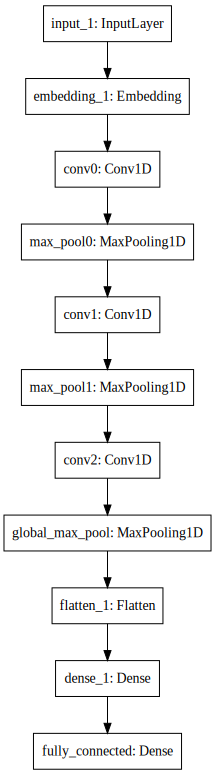

In [47]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [45]:
from keras.utils import plot_model
plot_model(model, to_file='cnn.png', show_shapes=True)